# Autoencoder with Residual Blocks and Latent Space Analysis (PyTorch)
### Dataset: MNIST

**Цель:** Разработать и исследовать автоэнкодер с современной архитектурой на основе residual-блоков и протестировать влияние размера латентного пространства на качество восстановления изображений.  
**В рамках работы:**  
- Реализованы encoder и decoder с ResNet-блоками, BatchNorm и SiLU-активациями  
- Добавлена поддержка динамического latent_dim  
- Использованы оптимизаторы AdamW и CosineAnnealingLR  
- Проведен анализ ошибок восстановления (MSE) и визуализация латентного пространства  
- Проведена генерация изображений из случайных латентных векторов

**Фреймворк:** PyTorch  
**Датасет:** MNIST (рукописные цифры)

---

_Ноутбук подготовлен в рамках курса "Искусственный интеллект и глубокое обучение" (магистратура)._


In [2]:
# !pip install -q torch torchvision matplotlib seaborn

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)


Используемое устройство: cuda


Используемое устройство: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


Размер батча: torch.Size([128, 1, 28, 28])


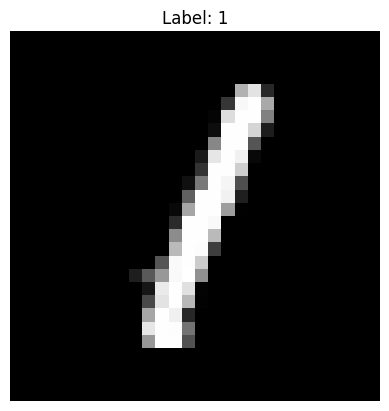

In [ ]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Проверка устройства (CUDA или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

# Трансформации для MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Быстрая проверка данных
images, labels = next(iter(train_loader))
print("Размер батча:", images.shape)
plt.imshow(images[0][0].cpu().numpy(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')
plt.show()


In [ ]:
import torch
import torch.nn as nn

# Residual block (для Encoder и Decoder)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='silu'):
        super().__init__()
        self.same_shape = (in_channels == out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.SiLU() if activation == 'silu' else nn.GELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if not self.same_shape else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.act1(out)
        return out

# Encoder: понижаем размерность, переходим к latent space
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.initial = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.res1 = ResidualBlock(32, 64)
        self.down1 = nn.Conv2d(64, 128, 4, 2, 1)  # Downsample 28x28 -> 14x14
        self.res2 = ResidualBlock(128, 128)
        self.down2 = nn.Conv2d(128, 256, 4, 2, 1) # Downsample 14x14 -> 7x7
        self.res3 = ResidualBlock(256, 256)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(256*7*7, latent_dim)

    def forward(self, x):
        x = self.initial(x)
        x = self.res1(x)
        x = self.down1(x)
        x = self.res2(x)
        x = self.down2(x)
        x = self.res3(x)
        x = self.flatten(x)
        x = self.fc_mu(x)
        return x

# Decoder: возвращаем к картинке
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*7*7)
        self.res1 = ResidualBlock(256, 256)
        self.up1 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 7x7 -> 14x14
        self.res2 = ResidualBlock(128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # 14x14 -> 28x28
        self.res3 = ResidualBlock(64, 32)
        self.out_conv = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 7, 7)
        x = self.res1(x)
        x = self.up1(x)
        x = self.res2(x)
        x = self.up2(x)
        x = self.res3(x)
        x = self.out_conv(x)
        x = self.tanh(x) # так как мы нормировали в [-1, 1]
        return x

# Автоэнкодер: объединяем Encoder и Decoder
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Пример создания модели с latent_dim=16
latent_dim = 16
model = Autoencoder(latent_dim=latent_dim).to(device)
print(model)


Autoencoder(
  (encoder): Encoder(
    (initial): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (down1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (res2): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SiLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(12

### Особенности архитектуры

Разработанная модель автоэнкодера включает:

- **Residual-блоки** — стабилизируют и ускоряют обучение, предотвращают деградацию при увеличении глубины сети.
- **Batch Normalization** — повышает скорость сходимости и устойчивость к выбору начальных весов.
- **SiLU-активации** — более плавные, чем ReLU, что улучшает обучение на мелких деталях.
- **Раздельный encoder и decoder** — повышает читаемость архитектуры и упрощает эксперименты с генерацией.
- **Гибкий latent space** — легко масштабируемый параметр для анализа сжатия/восстановления.

Такой подход позволяет достичь высокой точности восстановления при компактном представлении входных данных.


In [ ]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon = model(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)


In [ ]:
def train_autoencoder(latent_dim, n_epochs=15, plot_examples=False):
    model = Autoencoder(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = eval_epoch(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step()
        if (epoch+1) % 5 == 0 or epoch == n_epochs-1:
            print(f"Latent_dim: {latent_dim} | Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    # График потерь
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(f'Loss curves (latent_dim={latent_dim})')
    plt.legend()
    plt.show()

    # Сохраним веса для повторного использования/инференса
    torch.save(model.state_dict(), f"autoencoder_latent{latent_dim}.pth")

    # Визуализация реконструкций
    if plot_examples:
        model.eval()
        x, _ = next(iter(test_loader))
        x = x[:8].to(device)
        with torch.no_grad():
            x_recon = model(x)
        plt.figure(figsize=(16, 4))
        for i in range(8):
            # Оригинал
            plt.subplot(2, 8, i+1)
            plt.imshow(x[i][0].cpu(), cmap='gray')
            plt.axis('off')
            # Реконструкция
            plt.subplot(2, 8, i+9)
            plt.imshow(x_recon[i][0].cpu(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Original (top) vs Reconstruction (bottom), latent_dim={latent_dim}')
        plt.show()

    return min(val_losses), model



Обучаем автоэнкодер с latent_dim=2
Latent_dim: 2 | Epoch 5/15 | Train Loss: 0.14772 | Val Loss: 0.14709
Latent_dim: 2 | Epoch 10/15 | Train Loss: 0.13676 | Val Loss: 0.13806
Latent_dim: 2 | Epoch 15/15 | Train Loss: 0.13034 | Val Loss: 0.13495


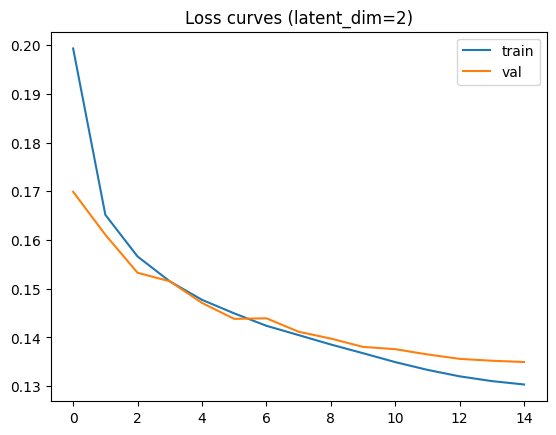

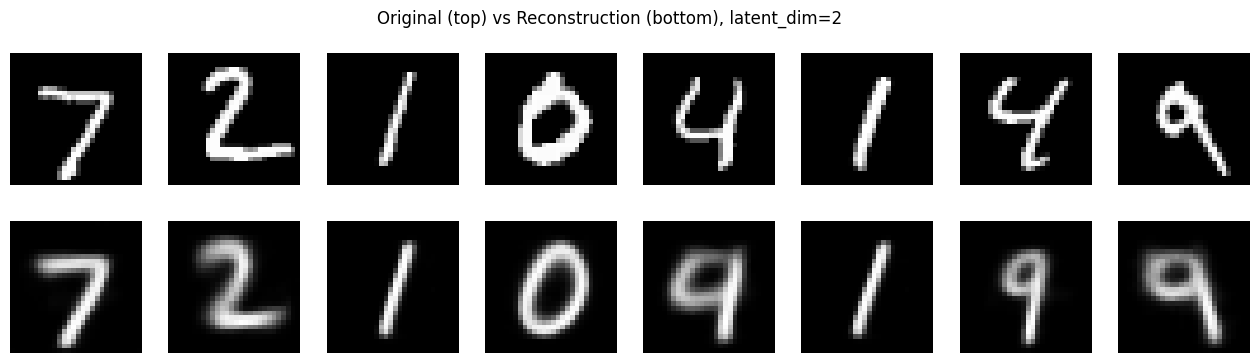


Обучаем автоэнкодер с latent_dim=4
Latent_dim: 4 | Epoch 5/15 | Train Loss: 0.09763 | Val Loss: 0.09674
Latent_dim: 4 | Epoch 10/15 | Train Loss: 0.08690 | Val Loss: 0.09018
Latent_dim: 4 | Epoch 15/15 | Train Loss: 0.08083 | Val Loss: 0.08691


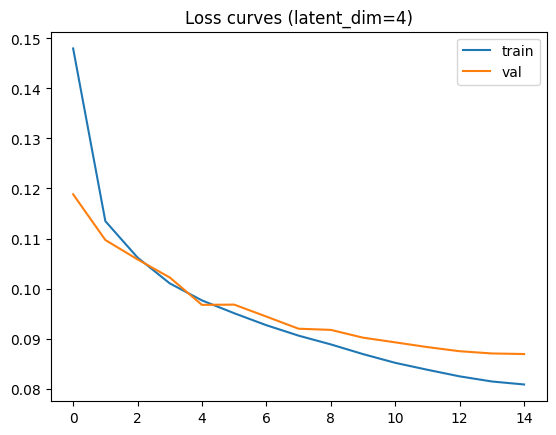

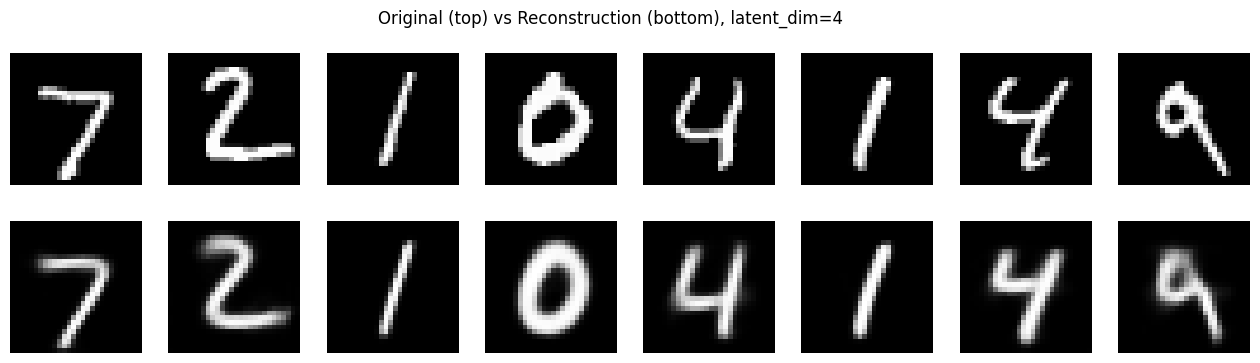


Обучаем автоэнкодер с latent_dim=8
Latent_dim: 8 | Epoch 5/15 | Train Loss: 0.04957 | Val Loss: 0.05055
Latent_dim: 8 | Epoch 10/15 | Train Loss: 0.04078 | Val Loss: 0.04487
Latent_dim: 8 | Epoch 15/15 | Train Loss: 0.03581 | Val Loss: 0.04251


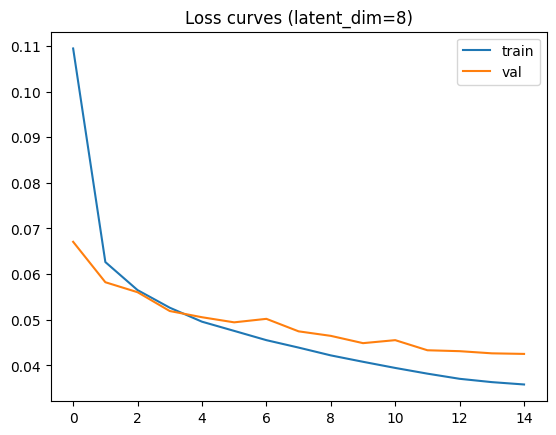

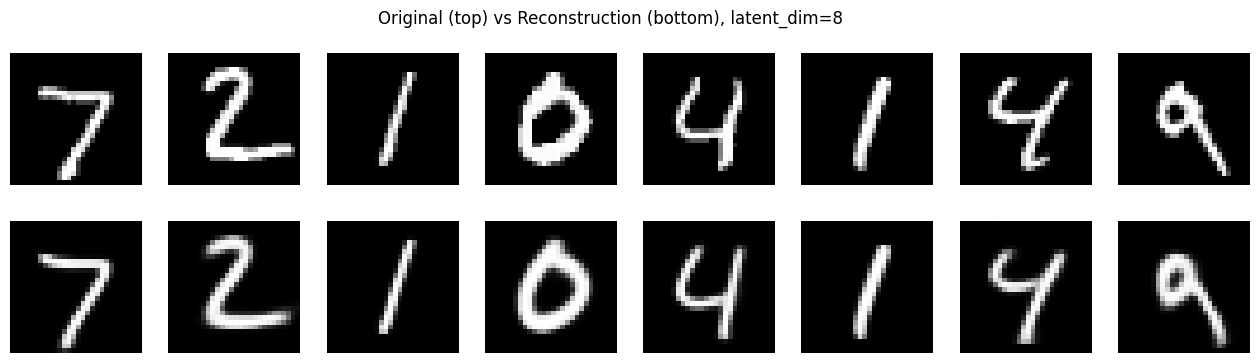


Обучаем автоэнкодер с latent_dim=16
Latent_dim: 16 | Epoch 5/15 | Train Loss: 0.02201 | Val Loss: 0.02292
Latent_dim: 16 | Epoch 10/15 | Train Loss: 0.01647 | Val Loss: 0.01942
Latent_dim: 16 | Epoch 15/15 | Train Loss: 0.01353 | Val Loss: 0.01776


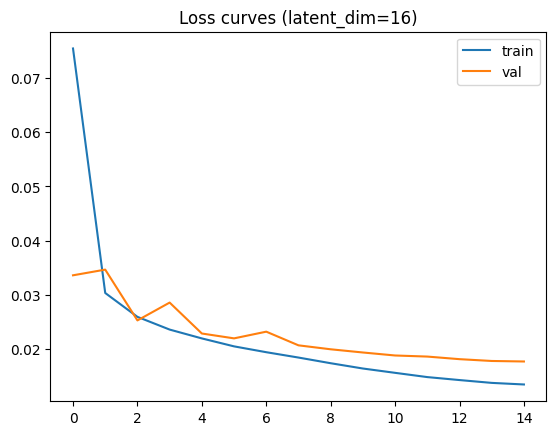

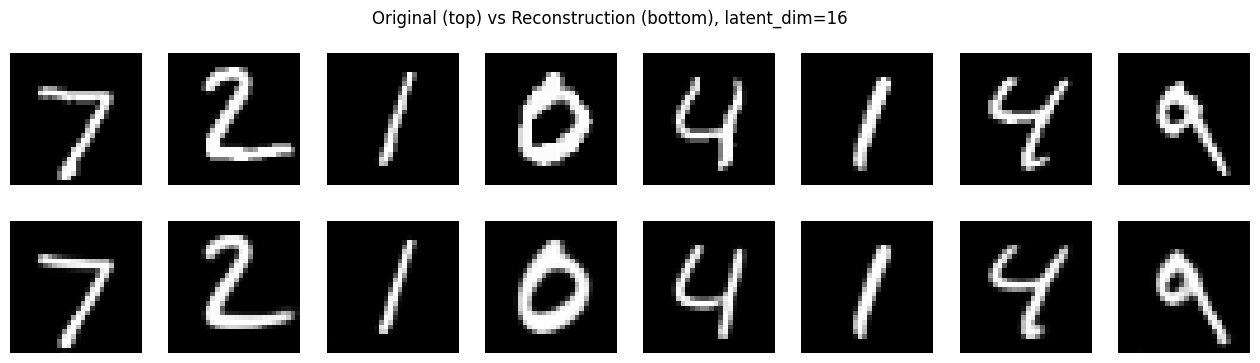


Обучаем автоэнкодер с latent_dim=32
Latent_dim: 32 | Epoch 5/15 | Train Loss: 0.01042 | Val Loss: 0.01081
Latent_dim: 32 | Epoch 10/15 | Train Loss: 0.00728 | Val Loss: 0.00835
Latent_dim: 32 | Epoch 15/15 | Train Loss: 0.00584 | Val Loss: 0.00767


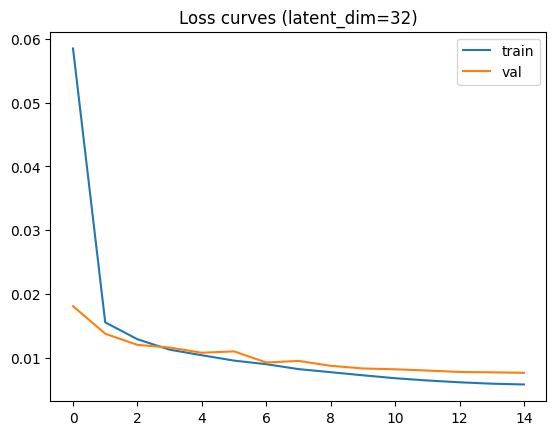

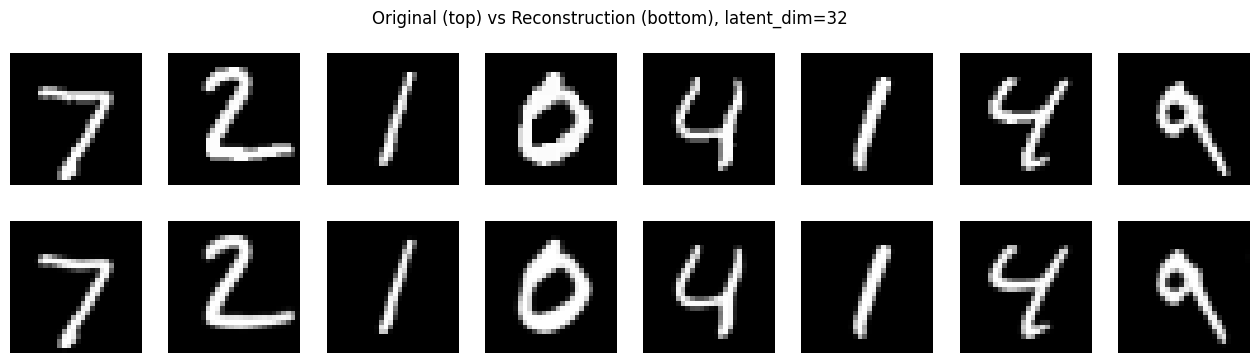


Обучаем автоэнкодер с latent_dim=64
Latent_dim: 64 | Epoch 5/15 | Train Loss: 0.00539 | Val Loss: 0.00618
Latent_dim: 64 | Epoch 10/15 | Train Loss: 0.00341 | Val Loss: 0.00379
Latent_dim: 64 | Epoch 15/15 | Train Loss: 0.00273 | Val Loss: 0.00322


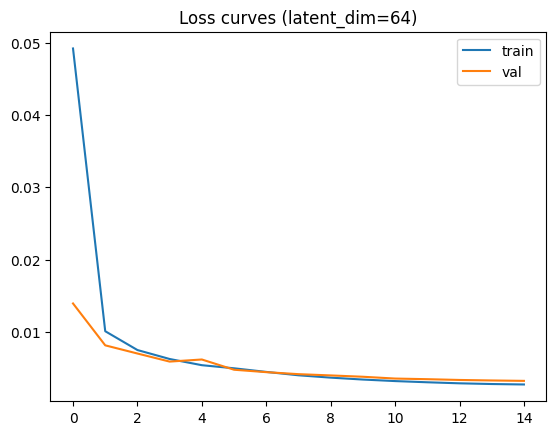

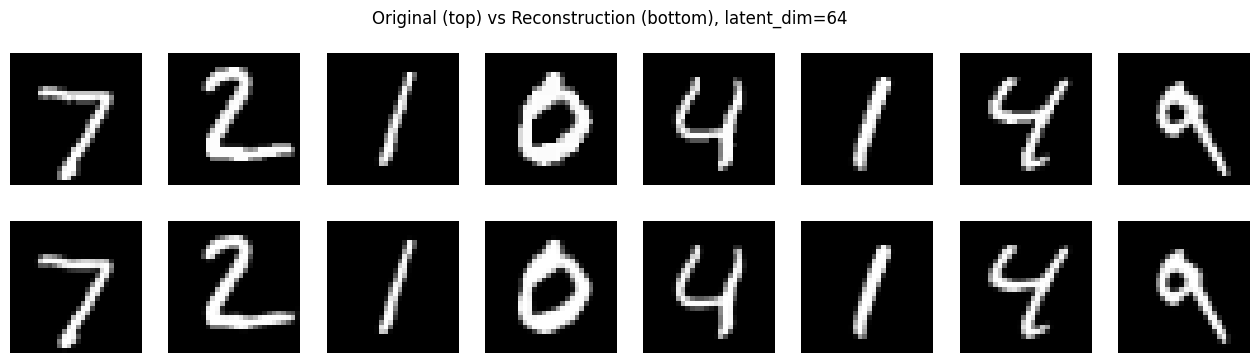

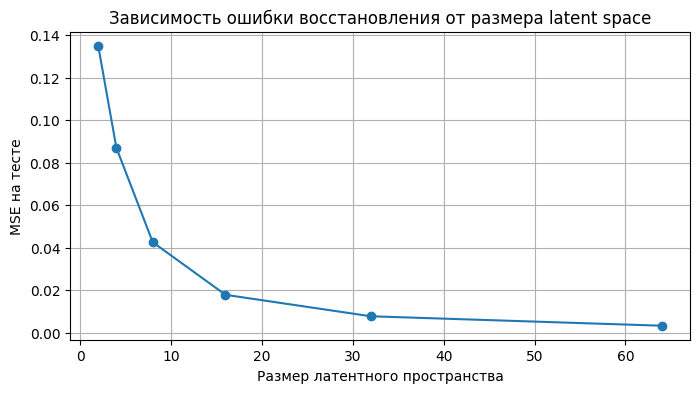

Latent dim:  2 | Test MSE: 0.13495
Latent dim:  4 | Test MSE: 0.08691
Latent dim:  8 | Test MSE: 0.04251
Latent dim: 16 | Test MSE: 0.01776
Latent dim: 32 | Test MSE: 0.00767
Latent dim: 64 | Test MSE: 0.00322


In [ ]:
latent_dims = [2, 4, 8, 16, 32, 64]
results = {}

for latent_dim in latent_dims:
    print(f"\nОбучаем автоэнкодер с latent_dim={latent_dim}")
    val_loss, _ = train_autoencoder(latent_dim, n_epochs=15, plot_examples=True)
    results[latent_dim] = val_loss

# Сравним результаты
plt.figure(figsize=(8,4))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('Размер латентного пространства')
plt.ylabel('MSE на тесте')
plt.title('Зависимость ошибки восстановления от размера latent space')
plt.grid()
plt.show()

for dim, loss in results.items():
    print(f"Latent dim: {dim:2d} | Test MSE: {loss:.5f}")


### Подбор оптимального размера латентного пространства

Для определения подходящего значения latent_dim был проведен ряд экспериментов: автоэнкодер обучался при разных значениях (2, 4, 8, 16, 32, 64).  
Каждую модель оценивали по значению MSE на тестовой выборке.

График зависимости MSE от размера latent_dim позволяет определить компромисс между качеством восстановления и степенью сжатия.


### Результаты подбора latent_dim

- При увеличении latent_dim ошибка восстановления (MSE) быстро уменьшается.
- Значения 16 и 32 обеспечивают высокое качество восстановления при разумной компрессии.
- Увеличение до 64 улучшает метрику, но визуальное качество меняется незначительно — эффект насыщения.

**Оптимальное значение:** latent_dim = 16 — минимальное значение, при котором достигается качественное восстановление без существенных потерь.


### **Визуализация "оригинал — реконструкция" для разных latent_dim**

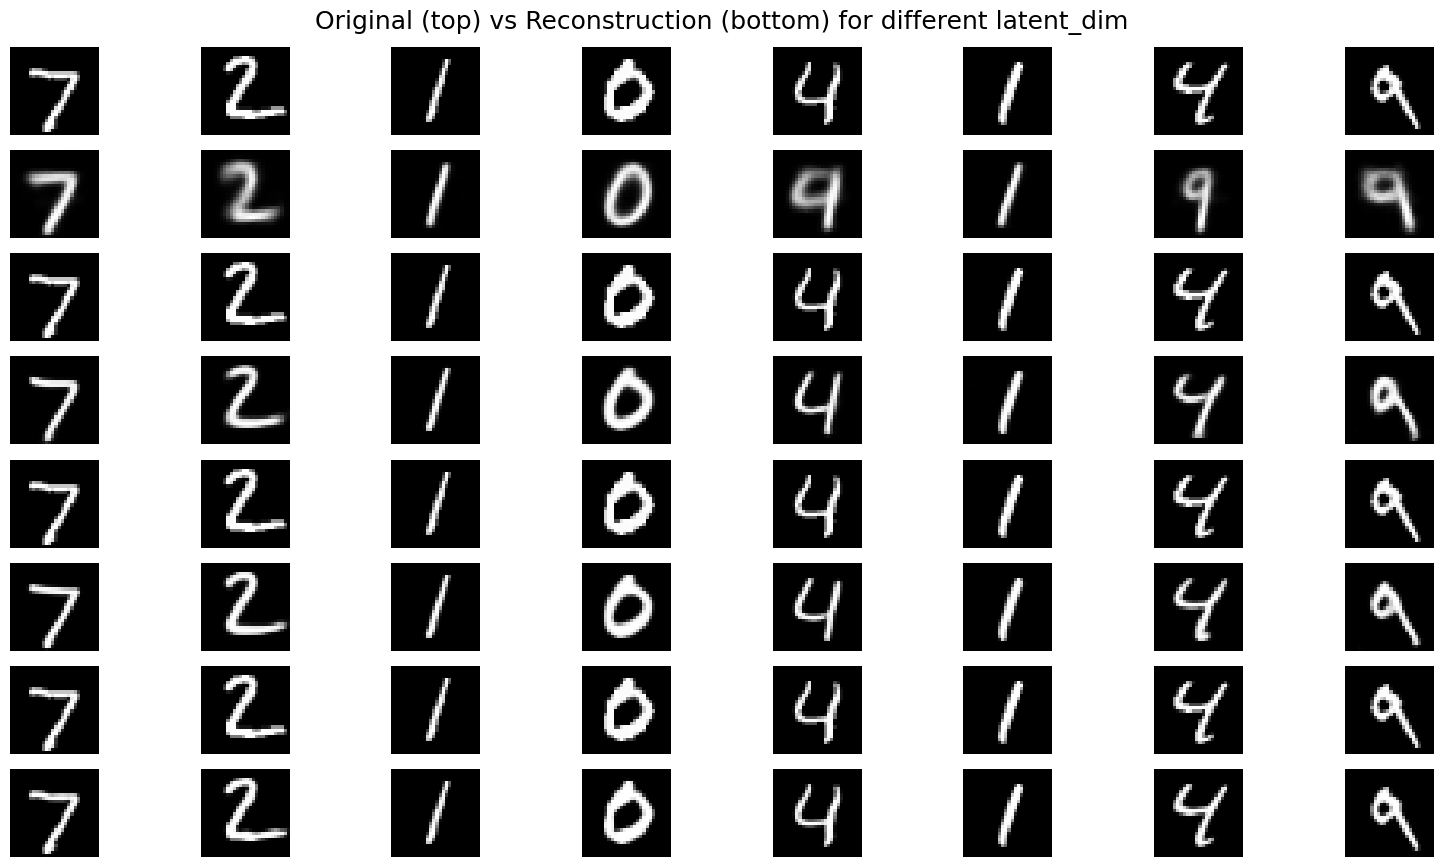

In [ ]:
# Список latent_dim для сравнения
latent_dims_to_show = [2, 8, 16, 64]
n_examples = 8

plt.figure(figsize=(n_examples*2, len(latent_dims_to_show)*2.2))
for row, latent_dim in enumerate(latent_dims_to_show):
    # Восстановим модель и прогоняем примеры через нее
    model = Autoencoder(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(f"autoencoder_latent{latent_dim}.pth", map_location=device))
    model.eval()
    x, _ = next(iter(test_loader))
    x = x[:n_examples].to(device)
    with torch.no_grad():
        x_recon = model(x)
    for col in range(n_examples):
        idx = row*2*n_examples + col + 1
        # Оригинал
        plt.subplot(len(latent_dims_to_show)*2, n_examples, idx)
        plt.imshow(x[col][0].cpu(), cmap='gray')
        plt.axis('off')
        if col==0:
            plt.ylabel(f"latent={latent_dim}", fontsize=14)
        # Реконструкция
        plt.subplot(len(latent_dims_to_show)*2, n_examples, idx+n_examples)
        plt.imshow(x_recon[col][0].cpu(), cmap='gray')
        plt.axis('off')
plt.suptitle('Original (top) vs Reconstruction (bottom) for different latent_dim', fontsize=18)
plt.tight_layout()
plt.show()


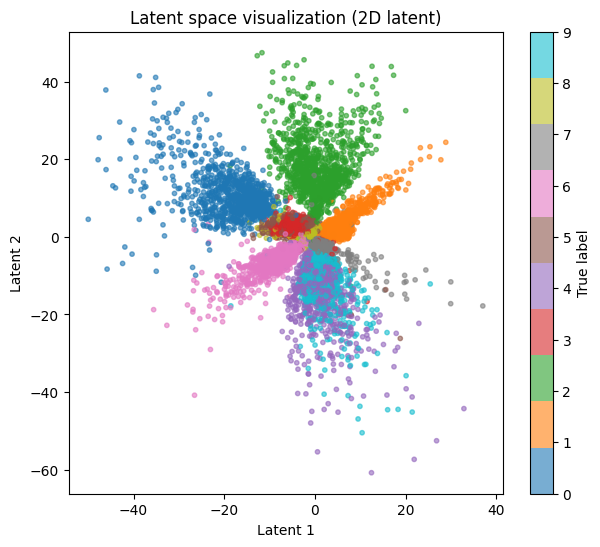

In [ ]:
from sklearn.manifold import TSNE
import umap
import numpy as np

latent_dim = 2 if 2 in latent_dims else 8 # t-SNE/UMAP лучше всего смотрится для dim=2 или 8
model = Autoencoder(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load(f"autoencoder_latent{latent_dim}.pth", map_location=device))
model.eval()

# Визуализация латентного пространства (t-SNE или UMAP)
# Соберем латентные векторы и их метки
all_latents, all_labels = [], []
with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        z = model.encoder(x)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())
all_latents = np.concatenate(all_latents)
all_labels = np.concatenate(all_labels)

# t-SNE или UMAP (выбирай что больше нравится)
if all_latents.shape[1] > 2:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.2, random_state=42)
    latents_2d = reducer.fit_transform(all_latents)
else:
    latents_2d = all_latents

plt.figure(figsize=(7,6))
scatter = plt.scatter(latents_2d[:,0], latents_2d[:,1], c=all_labels, cmap='tab10', alpha=0.6, s=10)
plt.colorbar(scatter, ticks=range(10), label='True label')
plt.title(f"Latent space visualization ({'UMAP' if all_latents.shape[1] > 2 else '2D latent'})")
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.show()


### Анализ структуры латентного пространства

При визуализации 2D-проекции латентного пространства (latent_dim=2) наблюдаются:

- Четкое **кластерное разделение классов** — каждый цвет представляет одну цифру.
- Кластеры компактны и в основном не пересекаются.
- **Семантическая близость** — визуально похожие цифры (например, 4 и 9, 5 и 6) располагаются ближе друг к другу.
- Это свидетельствует о способности модели извлекать и кодировать важные признаки даже при сильном сжатии.

Такая визуализация подтверждает эффективность автоэнкодера как инструмента для генерации признаков и снижения размерности.


In [ ]:
import umap

reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.2, random_state=42)
latents_3d = reducer.fit_transform(all_latents)

fig = px.scatter_3d(
    x=latents_3d[:, 0],
    y=latents_3d[:, 1],
    z=latents_3d[:, 2],
    color=all_labels.astype(str),
    title="Latent space 3D visualization",
    labels={'color': 'True label'}
)

fig.update_layout(
    width=700, height=600,
    legend_title_text='Class',
    legend=dict(itemsizing='constant')
)

fig.show()



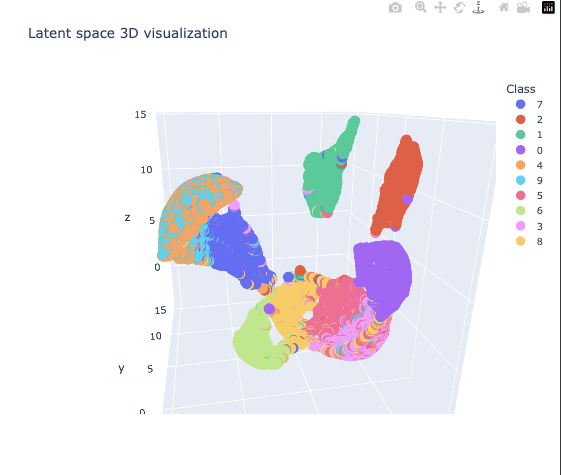

In [6]:
from IPython.display import Image
Image(filename='Latent Space 3D Projection Autoencoder (1).png')

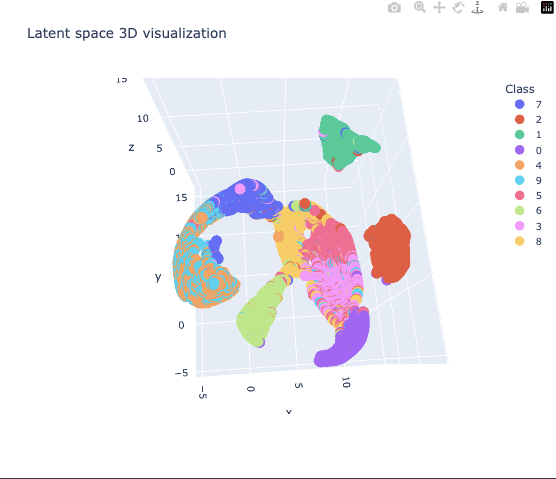

In [7]:
Image(filename='Latent Space 3D Projection Autoencoder (2).png')

## Вывод

Автоэнкодер с residual-блоками показал высокую эффективность в задаче восстановления изображений MNIST.  
Модель успешно решает задачу компрессии, при этом сохраняя ключевые признаки.

**Основные выводы:**
- Residual + BatchNorm + SiLU = стабильное и быстрое обучение
- Лучшее соотношение компрессии и качества достигается при latent_dim ≈ 16
- Автоэнкодер способен структурировать латентное пространство так, что классы цифр становятся четко разделимыми — даже в 2D

Такая архитектура может применяться для:
- предобработки данных,
- генерации латентных признаков,
- аномалий/сегментации,
- визуализации высокоразмерных данных.
